# Training a multi-task regression model for neural crest cells

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata

## Set experiment parameters

In [2]:
experiment = 'multi_task_DilatedConvModel'
if not os.path.exists(experiment):
    os.makedirs(experiment)
    
genome = 'danRer11' #"GRCz11"
seq_len = 500 # Length of the input sequence
training = False # Set to True to train model or False to use saved model 

## Load Data

In [3]:
data= pd.read_csv("../data/normalized_peaks.csv")
data.index.name = 'position #'
ad = data.to_numpy()
ad = anndata.AnnData(ad).T

# Prepare ad.obs
data.columns = [n.replace('/', '.').replace(' ','.').lower() for n in data.columns] # reformat for ensure downstream processing
cell_types = pd.DataFrame({'cell type': data.columns})
ad.obs = cell_types
ad.obs_names = ad.obs['cell type']

# Prepare ad.var
var = pd.read_csv("../data/chromosomes.10hpf.bed", sep = '\t', header = None)
var.columns = ['chrom', 'start', 'end', 'name', 'score', 'strand']
var = var.drop(columns =['name', 'score', 'strand'])
var.index = var.index.astype(str)
ad.var = var

ad.shape

(15, 370058)

In [4]:
cell_types

,cell type
cell type,
anterior.posterior.axis,anterior.posterior.axis
central.nervous.system,central.nervous.system
forebrain,forebrain
immature.eye,immature.eye
integument,integument
lateral.plate.mesoderm,lateral.plate.mesoderm
mesenchyme.cell,mesenchyme.cell
musculature.system,musculature.system
neural.crest,neural.crest


In [5]:
data

,anterior.posterior.axis,central.nervous.system,forebrain,immature.eye,integument,lateral.plate.mesoderm,mesenchyme.cell,musculature.system,neural.crest,neural.keel,neural.stem.cell,periderm.epidermis,primary.neuron,segmental.plate,ysl
position #,,,,,,,,,,,,,,,
0,4.658859,4.533672,3.744909,4.677198,3.910345,4.776952,4.074234,4.654862,4.511633,4.800124,3.995971,3.671893,3.417105,4.706086,3.662167
1,4.759777,4.715077,3.915141,4.802952,3.762256,4.759200,4.074087,4.553247,4.739486,4.790696,4.128371,3.930637,3.762256,4.786094,3.768121
2,4.851202,4.694130,3.741332,4.328792,3.891091,4.966067,4.201415,4.509935,4.834991,4.681877,3.961688,4.280661,4.920982,4.964999,4.249963
3,4.918804,4.971179,4.511633,4.538608,4.418892,4.899892,4.531088,4.722845,4.691382,4.823491,4.373438,4.534809,4.642561,5.069323,4.093997
4,5.091230,5.155695,4.589974,4.901204,4.731492,5.050992,4.468658,5.062934,5.074762,4.985431,4.415342,4.427364,4.779970,5.267927,4.454447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370053,2.385099,1.837305,1.710130,1.723122,2.184391,2.326503,1.820542,1.922973,1.471810,2.651219,2.077131,2.268933,1.552899,2.468091,2.502551
370054,3.310180,3.806458,2.857530,3.068696,3.365575,4.251009,3.218051,3.538135,3.645372,3.987058,3.310180,3.322940,3.442145,3.689176,2.822574
370055,2.983381,2.334474,2.777409,2.813908,2.786776,2.216906,3.053263,2.759981,3.251418,3.467993,2.507627,1.933072,2.805062,2.717196,1.456314


In [6]:
ad.obs

,cell type
cell type,
anterior.posterior.axis,anterior.posterior.axis
central.nervous.system,central.nervous.system
forebrain,forebrain
immature.eye,immature.eye
integument,integument
lateral.plate.mesoderm,lateral.plate.mesoderm
mesenchyme.cell,mesenchyme.cell
musculature.system,musculature.system
neural.crest,neural.crest


In [7]:
ad.obs_names

Index(['anterior.posterior.axis', 'central.nervous.system', 'forebrain',
       'immature.eye', 'integument', 'lateral.plate.mesoderm',
       'mesenchyme.cell', 'musculature.system', 'neural.crest', 'neural.keel',
       'neural.stem.cell', 'periderm.epidermis', 'primary.neuron',
       'segmental.plate', 'ysl'],
      dtype='object', name='cell type')

In [8]:
ad.var.head()

,chrom,start,end
0,chr1,5231,5732
1,chr1,5786,6287
2,chr1,10087,10588
3,chr1,10990,11491
4,chr1,11894,12395


In [9]:
ad.X[0:5,0:5]

array([[4.65885913, 4.7597768 , 4.8512016 , 4.91880367, 5.09123001],
       [4.53367234, 4.71507734, 4.69412965, 4.97117863, 5.155695  ],
       [3.74490908, 3.91514078, 3.74133195, 4.51163258, 4.58997422],
       [4.6771982 , 4.80295157, 4.3287915 , 4.53860808, 4.90120411],
       [3.91034461, 3.76225644, 3.89109145, 4.41889173, 4.7314921 ]])

## Filter peaks

Performing filtering of the dataset using `grelu.data.preprocess` module.

First, we filter peaks within autosomes (chromosomes 1 - 22) or chromosomes X/Y.

In [10]:
import grelu.data.preprocess

ad = grelu.data.preprocess.filter_chromosomes(ad, 'autosomes')

Keeping 333823 intervals


## Resize peaks

ATAC-seq peaks can take different lengths. Hence, we resize all ATAC-seq peaks to a constant sequence length of `seq_len`to train the model as follows:

In [11]:
import grelu.sequence.utils


ad.var = grelu.sequence.utils.resize(ad.var, seq_len)
ad.var.head(3)

/home/fgsasse_lrs_2/miniconda3/envs/lab-rotation/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,chrom,start,end
0,chr1,5232,5732
1,chr1,5787,6287
2,chr1,10088,10588


## Split data

In [12]:
ad.var['chrom'].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22'],
      dtype=object)

In [13]:
train_chroms='autosomes'
val_chroms=['chr3']
test_chroms=['chr4']


ad_train, ad_val, ad_test = grelu.data.preprocess.split(
    ad, 
    train_chroms = train_chroms, val_chroms = val_chroms, 
    test_chroms = test_chroms,
)

Selecting training samples
Keeping 303354 intervals


Selecting validation samples
Keeping 17079 intervals


Selecting test samples
Keeping 13390 intervals
Final sizes: train: (15, 303354), val: (15, 17079), test: (15, 13390)


## Make labeled sequence datasets

In [14]:
import grelu.data.dataset

In [15]:
train_dataset = grelu.data.dataset.AnnDataSeqDataset(
    ad_train.copy(),
    genome = genome,
    rc = True, #reverse complement
    max_seq_shift = 1, # Shift the sequence
    augment_mode = "random", # Randomly select which augmentations to apply
)

In [16]:
val_dataset = grelu.data.dataset.AnnDataSeqDataset(ad_val.copy(), genome=genome)
test_dataset = grelu.data.dataset.AnnDataSeqDataset(ad_test.copy(), genome=genome)

## Build model

Here we use the DiltatedConvModel

In [17]:
model_params = {
    'model_type':'DilatedConvModel', # Type of model
    'n_tasks': ad.shape[0], # Number of cell types to predict
    'crop_len':0, 
    'channels':512,
    'n_conv':8,
}

train_params = {
    'task':'regression', # regression
    'loss': 'mse', 
    'lr': 1e-4, # learning rate




      
    'logger': 'csv', # Logs will be written to a CSV file
    'batch_size':64,
    'max_epochs':10,
    'devices':0, # Either “cpu” or an integer or list of integers representing the indices of the GPUs for training
    'num_workers':8,
    'optimizer': 'adam',
    'save_dir':experiment,
    'checkpoint': True, # Save checkpoints
}

import grelu.lightning


model = grelu.lightning.LightningModel(model_params, train_params)

In [18]:
print(model)

LightningModel(
  (model): DilatedConvModel(
    (embedding): DilatedConvTrunk(
      (conv_tower): ConvTower(
        (blocks): ModuleList(
          (0): Stem(
            (conv): Conv1d(4, 512, kernel_size=(21,), stride=(1,), padding=same)
            (act): Activation(
              (layer): ReLU()
            )
            (pool): Pool(
              (layer): Identity()
            )
          )
          (1): ConvBlock(
            (norm): Norm(
              (layer): Identity()
            )
            (conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=same, dilation=(2,))
            (act): Activation(
              (layer): ReLU()
            )
            (pool): Pool(
              (layer): Identity()
            )
            (dropout): Dropout(
              (layer): Identity()
            )
            (channel_transform): ChannelTransform(
              (layer): Identity()
            )
          )
          (2): ConvBlock(
            (norm): Norm(
       

## Train model

In [19]:
if training:
    trainer = model.train_on_dataset(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
    )
else:
    trainer = None


## Load best model from checkpoint

In [20]:
try:
    best_checkpoint = trainer.checkpoint_callback.best_model_path
except:
    best_checkpoint = 'multi_task_DilatedConvModel/2025_04_05_18_52/version_0/checkpoints/epoch=8-step=42660.ckpt'
print(best_checkpoint)

multi_task_DilatedConvModel/2025_04_05_18_52/version_0/checkpoints/epoch=8-step=42660.ckpt


In [21]:
model = grelu.lightning.LightningModel.load_from_checkpoint(best_checkpoint)

## Evaluate model on the test set

In [22]:
test_metrics = model.test_on_dataset(
    test_dataset,
    devices=0,
    num_workers=8,
    batch_size=256,
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/fgsasse_lrs_2/miniconda3/envs/lab-rotation/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 53/53 [00:03<00:00, 16.18it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0542811155319214
        test_mse             1.056918740272522
      test_pearson          0.4273480176925659
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Inspect training curves

In [23]:
metrics_path = "multi_task_DilatedConvModel/2025_26_04_15_05/version_0/metrics.csv"

metrics_df = pd.read_csv(metrics_path)

metrics_df.head()

,epoch,step,train_loss_epoch,train_loss_step,val_loss,val_mse,val_pearson
0,0,0,NaN,NaN,7.56159,7.489322,NaN
1,0,49,NaN,1.032562,NaN,NaN,NaN
2,0,99,NaN,1.095526,NaN,NaN,NaN
3,0,149,NaN,1.007000,NaN,NaN,NaN
4,0,199,NaN,0.933161,NaN,NaN,NaN


In [24]:
# Checking if the 'epoch' and 'train_loss' columns exits
if 'epoch' in metrics_df.columns and 'train_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Training Loss', marker='o')
else:
    print("Columns 'epoch' or 'train_loss' not found in metrics file.")

Columns 'epoch' or 'train_loss' not found in metrics file.


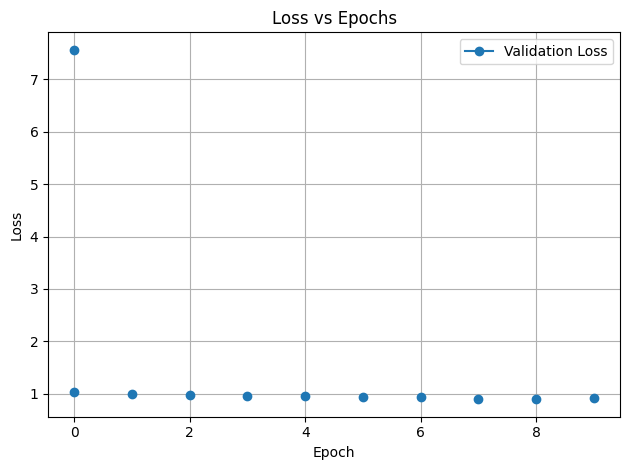

In [25]:
## Plotting validation loss (if logged)
if 'val_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss', marker='o')

    plt.title('Loss vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

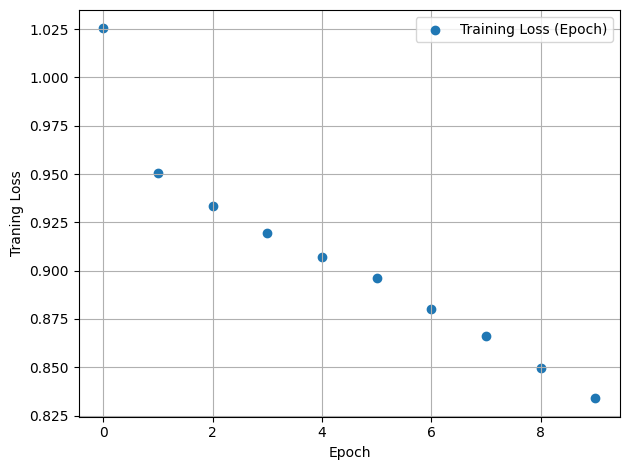

In [26]:
plt.scatter(metrics_df['epoch'], metrics_df['train_loss_epoch'], label='Training Loss (Epoch)', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Traning Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

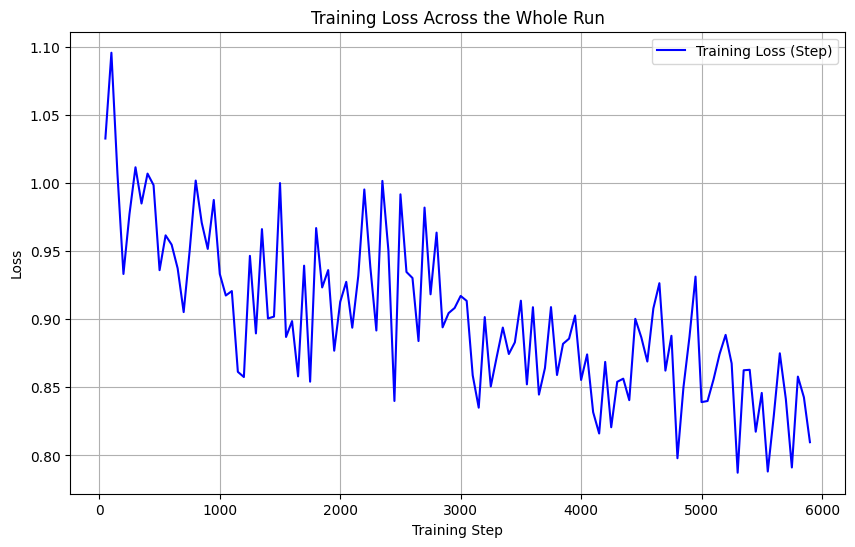

In [27]:
# plot training loss at each step
df_train = metrics_df.dropna(subset=['train_loss_step'])

plt.figure(figsize=(10, 6))
plt.plot(df_train['step'], df_train['train_loss_step'], label='Training Loss (Step)', color='blue')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training Loss Across the Whole Run')
plt.legend()
plt.grid(True)
plt.show()

## Run inference on held out sequences

In [28]:
preds = model.predict_on_dataset(
    test_dataset, devices=0, num_workers=8
    )
preds.shape

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 53/53 [00:03<00:00, 17.65it/s]


(13390, 15, 1)

In [29]:
preds_df = model.predict_on_dataset(
    test_dataset, devices=0, num_workers=8,
    return_df=True # Return the output as a pandas dataframe
    )
preds_df.head()

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 53/53 [00:02<00:00, 17.67it/s]


,anterior.posterior.axis,central.nervous.system,forebrain,immature.eye,integument,lateral.plate.mesoderm,mesenchyme.cell,musculature.system,neural.crest,neural.keel,neural.stem.cell,periderm.epidermis,primary.neuron,segmental.plate,ysl
0,1.952865,1.848212,2.437662,2.142968,1.736604,1.858803,1.751504,1.614553,1.850767,1.979452,2.250639,1.675154,2.740991,1.728445,2.033247
1,2.515197,2.519488,2.741953,2.618637,2.558317,2.420952,2.506791,2.357356,2.486439,2.542152,2.706110,2.545749,2.721695,2.400162,2.496948
2,1.633082,1.442782,1.686217,1.489672,1.675435,1.596057,1.487519,1.657820,1.626805,1.564059,1.512197,1.882031,1.654016,1.591885,2.052998
3,2.679340,2.425492,2.707216,2.652576,2.554535,2.678185,2.623496,2.321032,2.647836,2.733853,2.752631,2.565494,2.748413,2.506977,2.521661
4,2.927628,3.014585,2.952136,2.869371,2.736434,2.788816,2.777738,2.631112,2.884308,3.034631,3.002742,2.693385,2.673187,2.826448,2.428615


## Correlations for each cell type in test set

In [30]:
test_metrics.sort_values(by = 'test_pearson', ascending= False)

,test_mse,test_pearson
primary.neuron,0.985965,0.479837
neural.keel,0.994305,0.467977
neural.stem.cell,1.154680,0.465669
central.nervous.system,1.154538,0.463673
forebrain,1.057792,0.460135
mesenchyme.cell,1.110574,0.444304
lateral.plate.mesoderm,0.947347,0.440039
immature.eye,1.066211,0.433858
ysl,0.884884,0.421179
anterior.posterior.axis,1.001391,0.417980


In [31]:
ad.obs_names

Index(['anterior.posterior.axis', 'central.nervous.system', 'forebrain',
       'immature.eye', 'integument', 'lateral.plate.mesoderm',
       'mesenchyme.cell', 'musculature.system', 'neural.crest', 'neural.keel',
       'neural.stem.cell', 'periderm.epidermis', 'primary.neuron',
       'segmental.plate', 'ysl'],
      dtype='object', name='cell type')

## Inpsecting the performance of the trained model

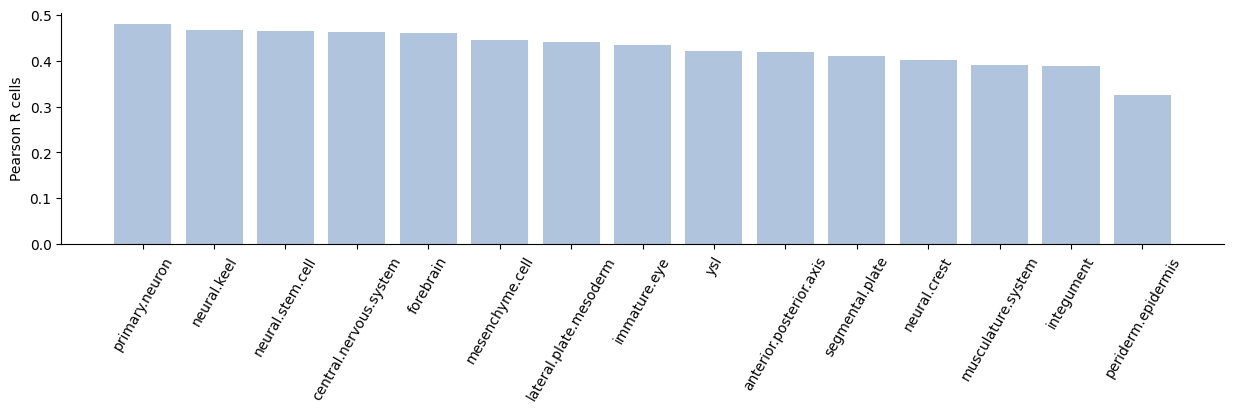

In [32]:
from plotlib import _bar_plot
import matplotlib.pyplot as plt

corrvalues_sorted = test_metrics.sort_values(by = 'test_pearson', ascending= False)

ax = _bar_plot(corrvalues_sorted['test_pearson'], ylabel = 'Pearson R cells', horizontal = False, xticklabels = corrvalues_sorted.index, rotation = 60)
plt.show()

## Interpreting model predictions and attributions for neural crest cells

**Note**: We want to find out what the model thinks that is important in the sequence to get a high signal.
grelu has a few methods that you can easily select (saliency, integratedgradients, and deepliftshap)
However, you won't be able to use deepliftshap if you trained a model with GELU or with attention

### Model performance for neural crest cell

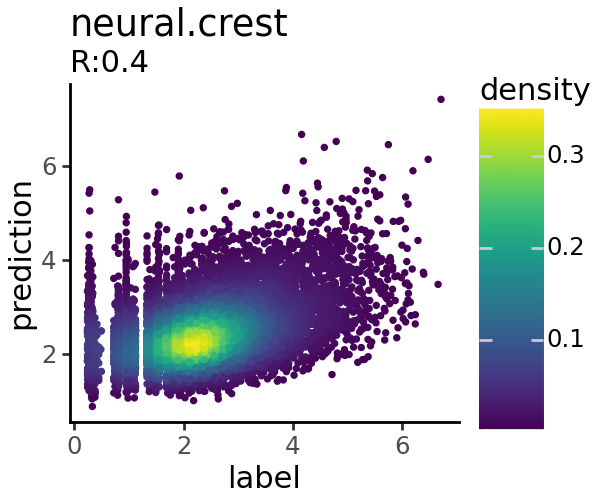

In [33]:
import grelu.visualize
%matplotlib inline
import plotnine as p9
from scipy.stats import pearsonr

fig = grelu.visualize.plot_pred_scatter(
    preds=preds,
    labels=test_dataset.get_labels(),
    tasks= [8],
    density=True, # Color points by local density
    figsize=(3, 2.5), # width, height
    size=.5
)



pcorr = str(round(test_metrics['test_pearson'].values[8], 2))
fig + p9.labs(title = f'{ad.obs_names[8]}',
              subtitle = f'R:{pcorr}') 

### Plot performance of model on all cell types

In [34]:
# create list of predictions
n = preds.shape[1]
preds_list = [preds[:,e,:].reshape(-1) for e in range(n)]
len(preds_list)

15

In [35]:
ad.obs_names

Index(['anterior.posterior.axis', 'central.nervous.system', 'forebrain',
       'immature.eye', 'integument', 'lateral.plate.mesoderm',
       'mesenchyme.cell', 'musculature.system', 'neural.crest', 'neural.keel',
       'neural.stem.cell', 'periderm.epidermis', 'primary.neuron',
       'segmental.plate', 'ysl'],
      dtype='object', name='cell type')

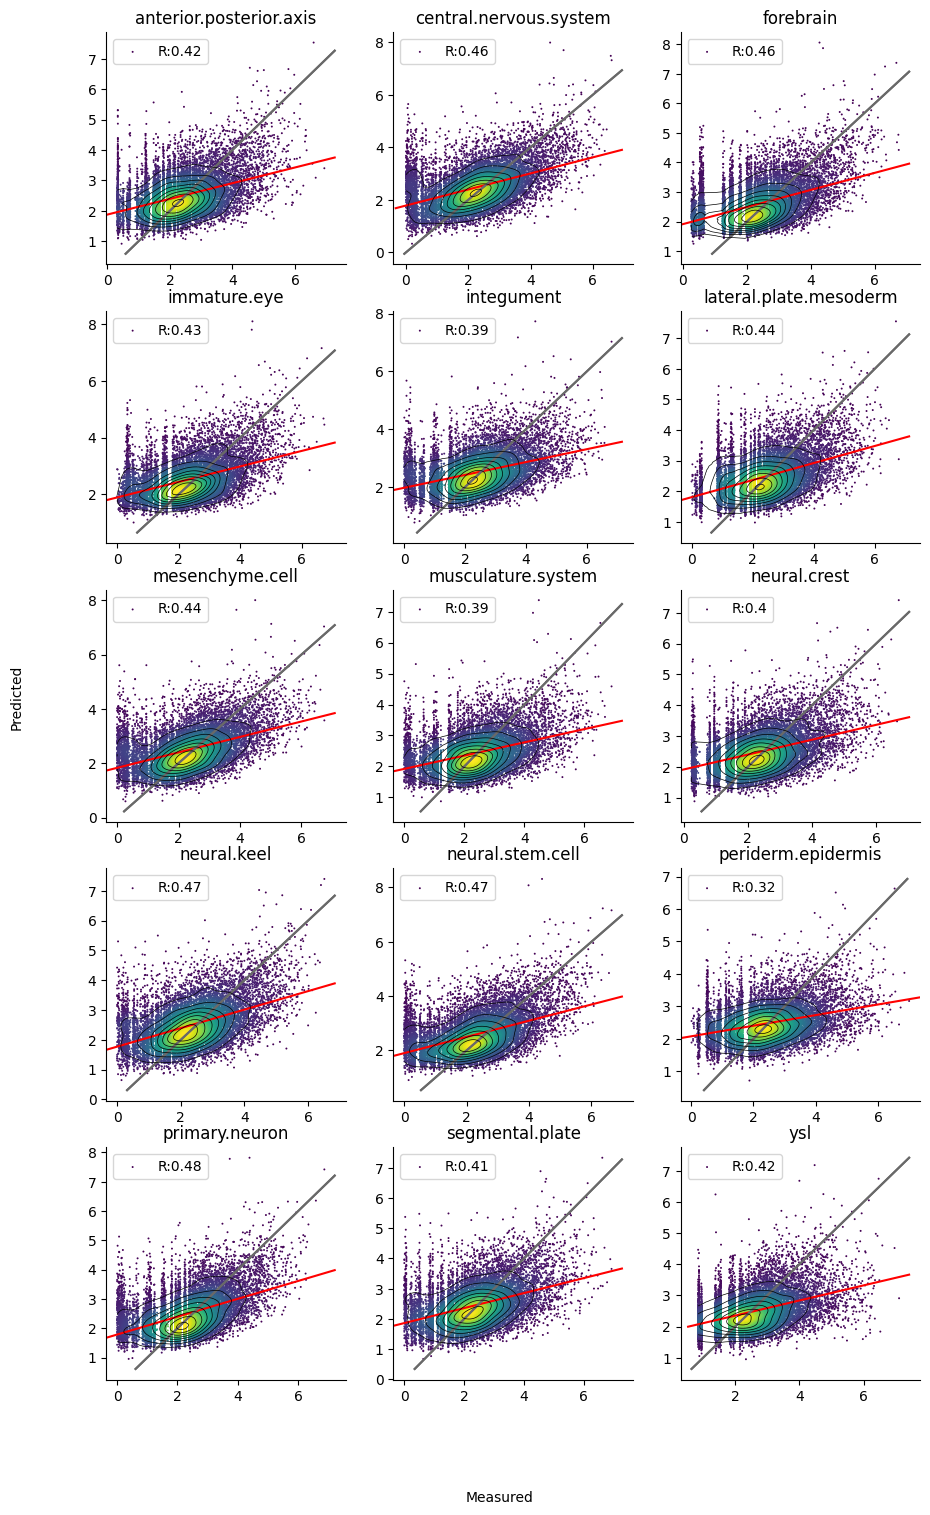

In [36]:
from plotlib import plot_scatter

allfig = plot_scatter(list(ad_test.X.toarray()), preds_list, titles = ad_test.obs_names, xlabel = 'Measured', ylabel = 'Predicted', 
                      sizes = 2, contour = True, color_density = True, color = 'grey', lw = 0., legend = True, 
                      include_fit = True, include_mainvar = False, diagonal = True)
plt.show()

### Selecting trusted well-predicted data points

In [37]:
# determine index for neural crest cell
nc_index = list(ad.obs_names).index('neural.crest')
nc_index

8

In [38]:
# select sequence with highest signal and close to measured
nc_test_actual = list(ad_test.X.toarray())[nc_index]
nc_test_pred = preds_list[nc_index]
test_mask = (np.abs(nc_test_actual - nc_test_pred) < 1.) & (nc_test_pred > 6.)
print(f'Selected {int(np.sum(test_mask))} sequences for neural crest cells')

Selected 3 sequences for neural crest cells


In [39]:
# indices of sequences
selected_indices = ad_test.var[test_mask]
selected_indices

,chrom,start,end
49455,chr4,20623,21123
56229,chr4,18666117,18666617
62189,chr4,74929056,74929556


In [40]:
import grelu.sequence.format

input_seqs = grelu.sequence.format.convert_input_type(
    selected_indices,
    output_type="strings",
    genome=genome
)


len(input_seqs)

3

In [41]:
input_seqs

['ACCGGGCAGCGGGCACGAGCACTCGCCGGTAATCCCTCGCCGATCAAACGCTTTGATTTCTCCTCAGAATCGACTTTTCACAGTGTAATAAAGCGCGCGCCCCTCCCTGCGGCTGCCACACACACACACTCGCACACTGCCGGACCGCCCGAGCCCCGCTGCCGACGCCCCGCCCCTCACCGCTCCCCTCACTCTGATTGGACAGCGGCCGGGACCTCCGCGACGGTGATTGGAGGAGCAGTCGCTTCACTCAAACGCATCCTCGGATTTCTGGTTCCTGACTGTCGGGACCGGCTGTCAATCAGAGGTTCCCCCTGAGCTTCTCTGCGATTGGCCGAGCCCGCTCCCGCCCTCTGCCTGAGCCAGGTTAGCCCCGCCTCTTCCGCGCTGACATCCGGGCTCTTTCAGCGCGTCACCGTCAGCGCATTGTCTCCGCGTTTGCGTGTAAATCCGTAACCCTGACGAGCAGCGAGAGAGCTGATCAACCGATCACCAGCAGC',
 'TCAACTGACCTGATCGACCACAGATTTGATTTTTTCCTCAGGACTCATAAGAAATGACACATTTTCAGACACCCTTTCTGCCGCCGCAGAGGTAGCAGTGCGCTCGCAGCAGTGGTGGTCTCTCTTGGGCCCCTGCGGGCACGTGTCTACAGGACTCCTCAATTACAGAGGTGAAATCTGAGGTCAGCCTCTGTAGAGAGAGGAACAAAGGGCACGACCCAAGGGTCAAAAGTGCTAGACTGGAAGCAGGCTGGTCCCCATTGAGAGGGAGGGTGCTGTTTGCTTTGTGTAGGTAAAGAGTACTAAAACACAGACAAACAGAGATTAAGAGGTGAGCCCCTTAGGACTGTCACTCAGAGGGCCCCTCCATCAACTCCGATTAACTCCCTTGACCTCTGCCTGCCATTAGACGATGCTTAATGACCCTTACGACTCGCAGCCGCACTCAAAGAAGCAAAAGTCGAGTTACGTAGTTACCTCACTTCAGCTGACA

In [42]:
len(input_seqs[0])

500

In [43]:
input_seqs[0][:10]

'ACCGGGCAGC'

### Using integrated gradients from Captum

In [44]:
from grelu.transforms.prediction_transforms import Aggregate

neural_crest_peaks = Aggregate(
    tasks = ["neural.crest"],
    model = model,
)

neural_crest_peaks

Aggregate()

In [45]:
from utils import get_captum_integrated_gradients


captum_attrs = get_captum_integrated_gradients(
    model, input_seqs, genome, prediction_transform=neural_crest_peaks, device=0,
    multiply_by_inputs= False,
)

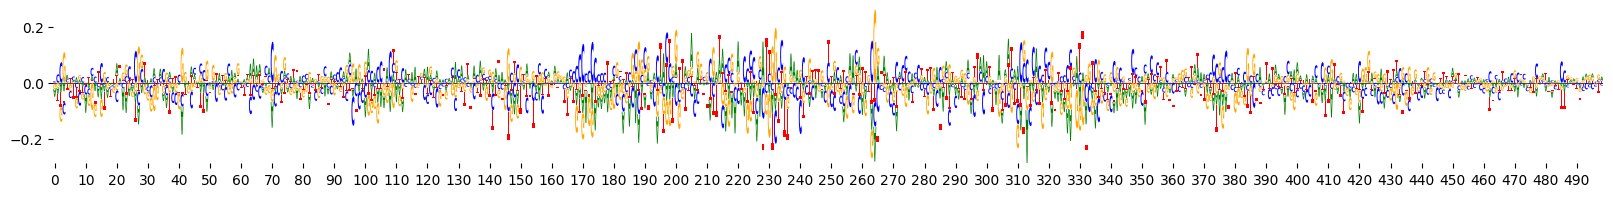

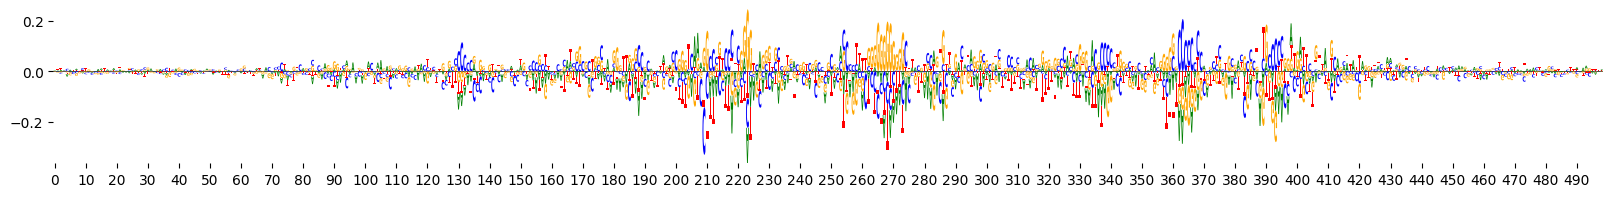

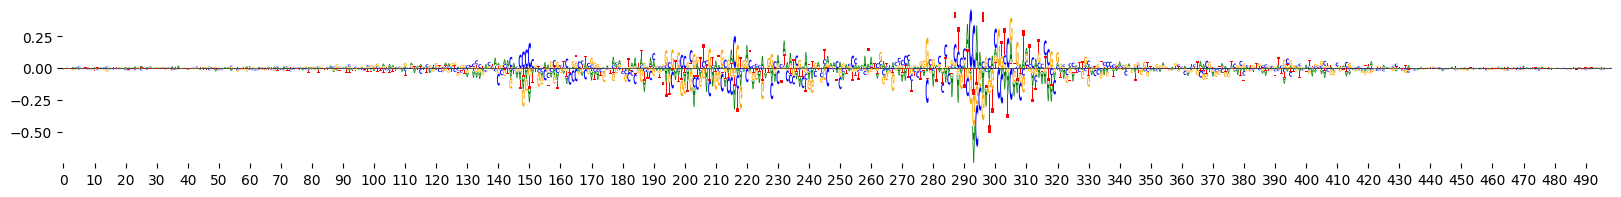

In [46]:
for s in range(len(input_seqs)):
    grelu.visualize.plot_attributions(
        captum_attrs[s,:,:], 
        ticks=10,
    )

    _ = plt.show()

#### For each sequence, substract the mean across the nucleotide axis (column) from each nucleotide (element in the column)

In [47]:
mean_captum_attrs = np.mean(captum_attrs, axis = -2, keepdims= True)
z_captum_attrs = captum_attrs - mean_captum_attrs

In [48]:
input_seqs_one_hot = grelu.sequence.format.strings_to_one_hot(input_seqs)
input_seqs_one_hot = input_seqs_one_hot.numpy()

#### Multiply the standardized attributions with the one-hot encoded sequences

In [49]:
attrs_mult_input = z_captum_attrs*input_seqs_one_hot

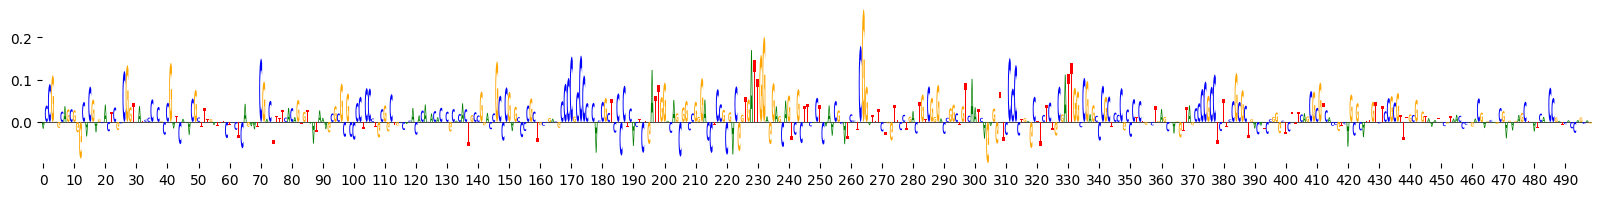

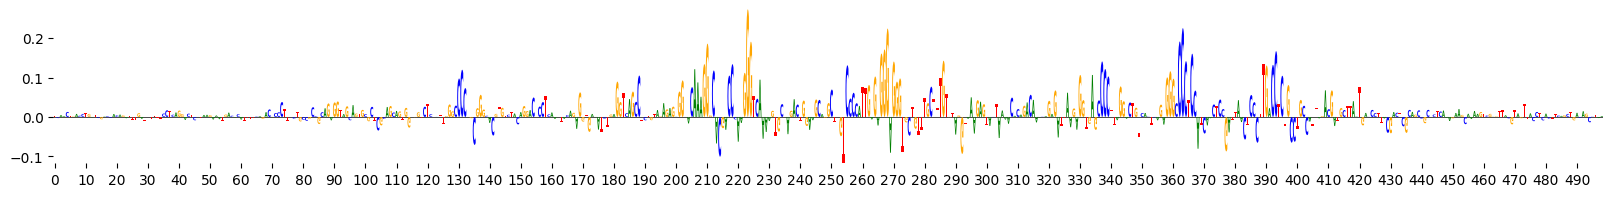

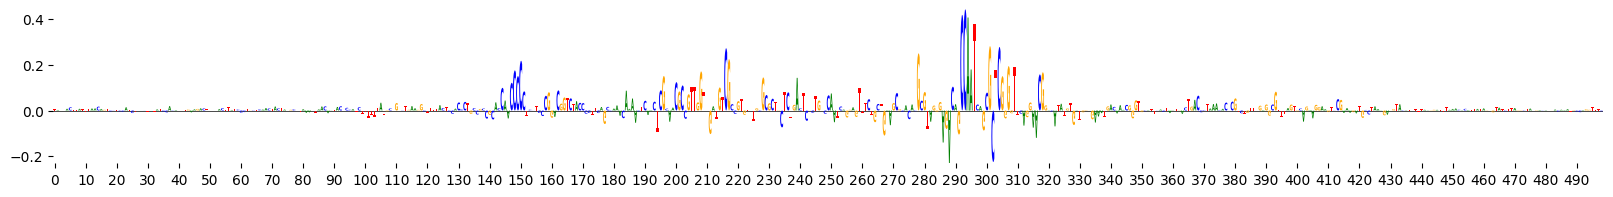

In [50]:
for s in range(len(input_seqs)):
    grelu.visualize.plot_attributions(
        attrs_mult_input[s,:,:], 
        ticks=10,
    )

    _ = plt.show()

#### Now use the captum integrated gradients again and set `multiply_by_inputs = True`

In [51]:
captum_attrs = get_captum_integrated_gradients(
    model, input_seqs, genome, prediction_transform=neural_crest_peaks, device=0,
    multiply_by_inputs= True,
)

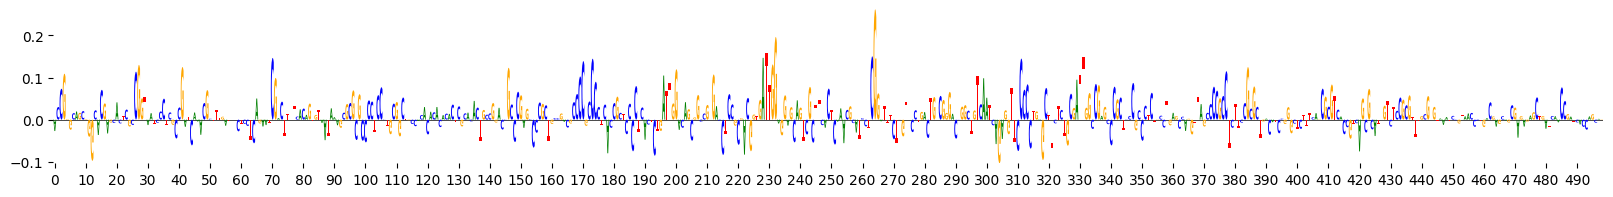

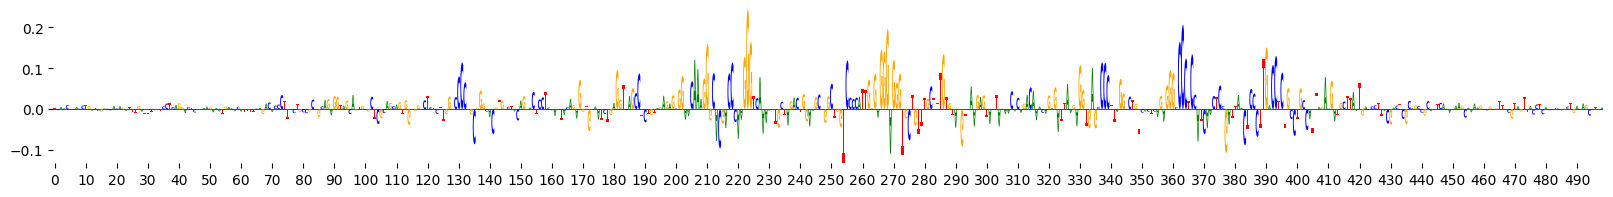

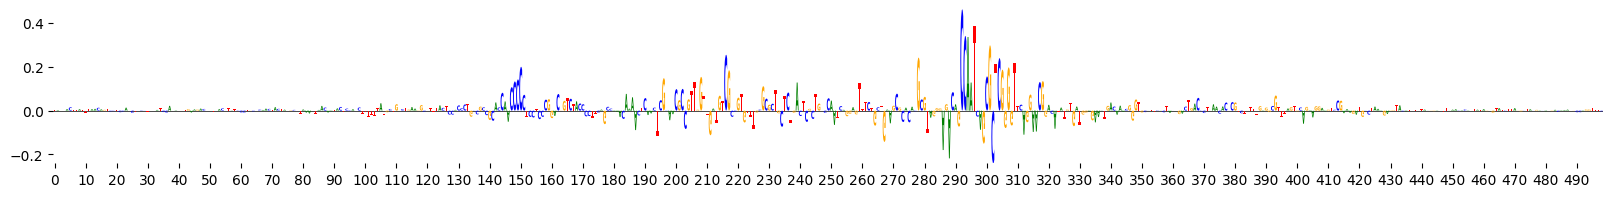

In [52]:
for s in range(len(input_seqs)):
    grelu.visualize.plot_attributions(
        captum_attrs[s,:,:], 
        ticks=10,
    )

    _ = plt.show()

### Systematically extract motifs from the computed sequence attributions

In [53]:
test_actual = np.array(list(ad_test.X.toarray())).T
test_pred = np.array(preds_list).T
test_mask_motifs = np.sum((np.abs(test_actual - test_pred) < 1.) * (test_pred > 5.), axis = 1) > 1
print(f'Selected {int(np.sum(test_mask_motifs))} sequences that differ at most 1 in cell types where they have signal over 5')

Selected 61 sequences that differ at most 1 in cell types where they have signal over 5


In [54]:
selected_indices = ad_test.var[test_mask_motifs]
selected_indices.head()

,chrom,start,end
49455,chr4,20623,21123
49459,chr4,28154,28654
49484,chr4,62269,62769
49493,chr4,74116,74616
49520,chr4,119542,120042


In [55]:
selected_indices.shape

(61, 3)

In [56]:
selected_seqs = grelu.sequence.format.convert_input_type(
    selected_indices,
    output_type="strings",
    genome=genome
)

In [57]:
selected_seqs_one_hot = grelu.sequence.format.strings_to_one_hot(selected_seqs)
selected_seqs_one_hot = selected_seqs_one_hot.numpy()
selected_seqs_one_hot.shape

(61, 4, 500)

In [58]:
cell_types = list(ad_test.obs_names)
ig_attrs_list = []

for cell_type in cell_types:
    prediction_transform = Aggregate(
        tasks = [cell_type],
        model = model,
    )

    ig_attrs = get_captum_integrated_gradients(model, selected_seqs, genome, prediction_transform, device=0, multiply_by_inputs= False)
    mean_ig_attrs = np.mean(ig_attrs, axis = -2, keepdims= True)
    z_ig_attrs = ig_attrs - mean_ig_attrs
    ig_attrs_mult_input = z_ig_attrs*selected_seqs_one_hot
    ig_attrs_list.append(ig_attrs_mult_input)

In [59]:
len(ig_attrs_list)

15

In [60]:
# Transform list of length 15 with each element of shape (# selected_seqs, 4, 500) into a numpy array of shape (# selected_seqs, 15, 4, 500):

# Step 1: Stack into a single array of shape (15, 37, 4, 500)
stacked = np.stack(ig_attrs_list, axis=0)

# Step 2: Transpose to shape (37, 15, 4, 500)
gradattr = np.transpose(stacked, (1, 0, 2, 3))

gradattr.shape

(61, 15, 4, 500)

In [61]:
sigcut = 1.95 * np.mean(np.std(gradattr, axis = (-1,-2)))
print(f'Estimated cutoff for significance from standard deviation {sigcut}')

Estimated cutoff for significance from standard deviation 0.04609461558689054


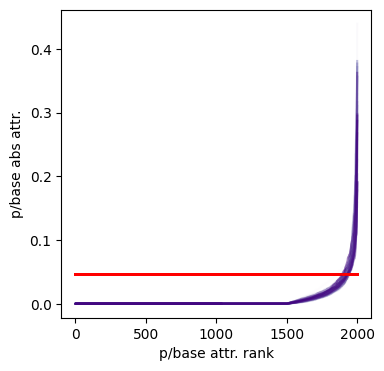

(61, 15, 4, 500) (61, 4, 500)
(61, 15, 500)


In [62]:
from motif_analysis import find_motifs
%matplotlib inline
import matplotlib.pyplot as pl
import matplotlib.pyplot as plt

# Plot distribution of absolute attribution effect against their rank
# To determine best estimate for significance cut off 
nd = 37
rt = 8
colors = pl.cm.Purples(np.linspace(0,1,nd))
fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot(111)
for i in range(nd):
    absgrad = np.abs(gradattr[i,rt].flatten())
    absgrad = np.sort(absgrad)
    rank = np.argsort(np.argsort(absgrad))
    ax.plot(rank, absgrad, alpha = 0.5, c = colors[i])
    ax.plot(rank, np.ones(len(rank))*sigcut, c = 'r')
ax.set_xlabel('p/base attr. rank')
ax.set_ylabel('p/base abs attr.')
plt.show()

# Use this cutoff to extract motifs from attributions for all tracks
# also record the mean and max effect, and scale attributions to abs max of 1 to cluster smaller motifs with larger ones
maxgap = 1 # Define max allowed gap
minsig = 4 # Define minumum number of significant bases
# Motifs are detected on the attributions of the reference base
print(gradattr.shape, selected_seqs_one_hot.shape)
stats = np.sum(gradattr * selected_seqs_one_hot[:, None], axis = -2)
print(stats.shape)
# From experience, we have seen that sometimes xAI methods can smear the attributions
# We don't want to include long motifs with no significance, so we also restrict ourselves 
# to motifs shorter than 30bp

In [63]:
selected_names = selected_indices.index
selected_names

Index(['49455', '49459', '49484', '49493', '49520', '49579', '49845', '50150',
       '50179', '50232', '50816', '51082', '51718', '51872', '51880', '52178',
       '52382', '52500', '52696', '52937', '53052', '53150', '53175', '53812',
       '53899', '53967', '54017', '54021', '54054', '54169', '54353', '54970',
       '55475', '55650', '55660', '55881', '55978', '56220', '56229', '56247',
       '56313', '56492', '56527', '56722', '56782', '57176', '57436', '57437',
       '57784', '57837', '57854', '58344', '58691', '59233', '61396', '61678',
       '61715', '62189', '62753', '62759', '62772'],
      dtype='object')

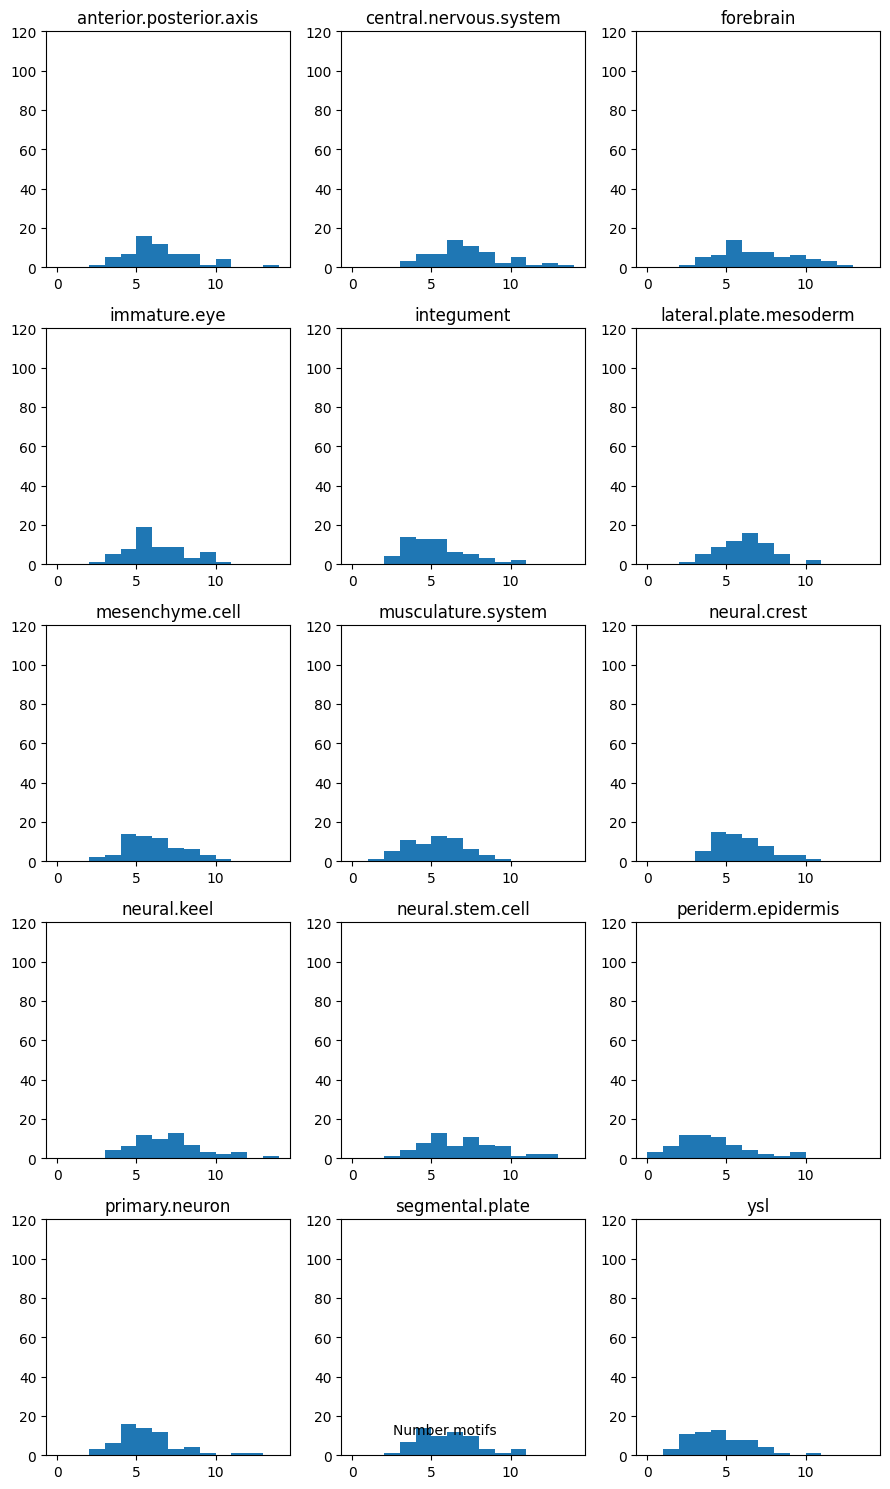

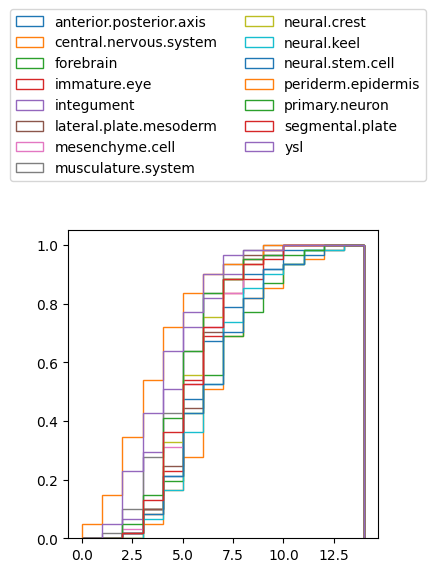

In [69]:
%matplotlib inline
max_motlen = 30
normed_motifs = []
motif_mean_effect = []
motif_max_effect = []
motif_borders = []
motif_names = []
N_motifs = []
for c, ct in enumerate(cell_types):
    norm_mot, mot_mean, mot_max, mot_bor, n_mot, mot_name = [], [], [], [], [], []
    for i in range(gradattr.shape[0]):
        motiflocs = find_motifs(stats[i, c], sigcut, maxgap, minsig) # Returns a list of lists with positions of the motifs
        n_mot.append(len(motiflocs))
        for ml in motiflocs: 
            if ml[-1]-ml[0] < max_motlen:
                mot_bor.append([ml[0], ml[-1]+1])
                # Negative or positive max
                mot_max.append(stats[i, c][ml[0]: ml[-1]+1][np.argmax(np.abs(stats[i, c][ml[0]: ml[-1]+1]))])
                mot_mean.append(np.mean(stats[i, c][ml[0]: ml[-1]+1]))
                norm_mot.append(gradattr[i, c][:, ml[0]: ml[-1]+1]/mot_max[-1]) # To max normalized and sign adjusted motif
                mot_name.append(f'{selected_names[i]}_{ct}_{ml[0]}-{ml[-1]+1}')
            
    normed_motifs.append(norm_mot)
    motif_mean_effect.append(np.array(mot_mean))
    motif_max_effect.append(np.array(mot_max))
    motif_borders.append(np.array(mot_bor,dtype = int))
    N_motifs.append(n_mot)
    motif_names.append(np.array(mot_name, dtype = str))

output_path = os.path.expanduser('../results/')
model_stem = best_checkpoint.replace('/', '.')
# Save the seqlets
seqlet_file = os.path.join(output_path, model_stem) + '_seqlets.npz'
np.savez_compressed(seqlet_file, names = np.array(motif_names, dtype = object), seqnames = selected_names, 
                    cells = cell_types, seqlets = np.array(normed_motifs, dtype = object), 
                    mean_effect = np.array(motif_mean_effect, dtype = object), max_effect = np.array(motif_max_effect, dtype = object), 
                    borders = np.array(motif_borders, dtype = object))

# For every cell type, plot the distribution of the number of motifs
fig, axes = plt.subplots(5, 3, figsize = (3 *3, 5*3))
for h, head in enumerate(cell_types):
    ax = axes[h//3,h%3]
    ax.hist(N_motifs[h], bins = np.arange(15))
    ax.set_title(head)
    ax.set_ylim([0,120])
plt.tight_layout()
fig.text(0.5, 0.04, 'Number motifs', ha='center')

figagg = plt.figure(figsize = (4,4))
axagg = plt.subplot(111)
for h, head in enumerate(cell_types):
    axagg.hist(N_motifs[h], bins = np.arange(15), cumulative=True, histtype = 'step', density = True, label = head)
figagg.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=2)

plt.show()

### Cluster motifs and combine

Distance matrix of size (5023, 5023) computed in 13.302639961242676
Clustering with matrix of size (5023, 5023) computed in 0.2806823253631592


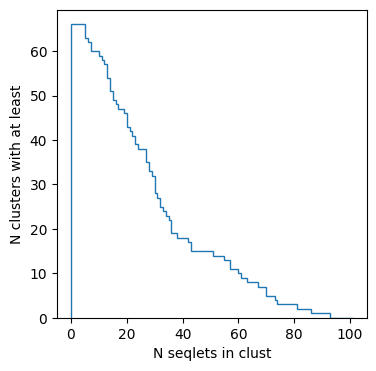

78
Saved PWM File as : ../results/multi_task_DilatedConvModel.2025_04_05_18_52.version_0.checkpoints.epoch=8-step=42660.ckpt_seqlets_cluster_cwms.meme


In [65]:
from motif_analysis import combine_pwms, torch_compute_similarity_motifs, assign_leftout_to_cluster
import numpy as np
from io_utils import write_meme_file
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import time

# Load saved seqlets
output_path = os.path.expanduser('../results/')
model_stem = best_checkpoint.replace('/', '.')
seqlet_file = os.path.join(output_path, model_stem) + '_seqlets.npz'
sfile = np.load(seqlet_file, allow_pickle= True)
selected_names, motif_names, header, normed_motifs, motif_mean_effect, motif_max_effect, motif_borders = sfile['seqnames'], sfile['names'], sfile['cells'], sfile['seqlets'], sfile['mean_effect'], sfile['max_effect'], sfile['borders']

# Make it a list and provide the seqlets in shape (l,4) to the algorithm
normed_motifs = [nm.T for nmm in normed_motifs for nm in nmm]
# Compute distance matrix between all seqlets from all cell types
# if return_alignment = True, then it returns the best offsets, and a binary matrix if the forward or reverse motif was aligned
# As distance metric, we are using the pvalue of the correlation coefficient
t0 = time.time()
motif_distance, offsets, revcomp_matrix = torch_compute_similarity_motifs(normed_motifs, normed_motifs, 
                                    metric = 'correlation_pvalue', min_sim = 4, padding = 0., infocont = False, 
                                    bk_freq = 0.25, reverse_complement = True, verbose = False, device = 'cuda:0', 
                                    batchsize = 1024, exact = True, fill_logp_self = 127, return_alignment = True, 
                                    sparse = False)
print(f'Distance matrix of size {motif_distance.shape} computed in {time.time()-t0}')
# With a distance matrix, one can use an clustering algorithm that to determine groups
# Agglomerative clustering has the advantage that it is highly interpretable and that we can use a distance threshold
# instead of defining a fixed number of clusters
# We use complete linkage and a threshold of 0.05, i.e. every motif in the cluster has a p-value < 0.05 to all other motifs
# in the same group
t0 = time.time()
clustering = AgglomerativeClustering(n_clusters = None, metric = 'precomputed', linkage = 'complete', 
                                     distance_threshold = 0.05)
clustering.fit(motif_distance)
print(f'Clustering with matrix of size {motif_distance.shape} computed in {time.time()-t0}')
clusters = clustering.labels_

# We save the cluster assignments to a file
np.savetxt(os.path.splitext(seqlet_file)[0]+'_cluster.txt', np.array([np.concatenate(motif_names, axis = 0), clusters], dtype = str).T, fmt = '%s')
# Let check how many seqlets are in each cluster
cluster_ids, n_seqlets = np.unique(clusters, return_counts=True)
fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot(111)
n_seqlets[n_seqlets > 101] == 101
ax.hist(n_seqlets, bins = np.arange(0,102,1), cumulative = -1, histtype='step')
ax.set_xlabel('N seqlets in clust')
ax.set_ylabel('N clusters with at least')
plt.show()


# TODO: Alternatively select a random subset of 10%, compute distance matrix for it, cluster and later assign held out motifs to cluster
# This saves resources but requires more time

# Combine sequences to CWM and save as meme file
cluster_cwms = combine_pwms(normed_motifs, clusters, 1.-motif_distance, offsets, revcomp_matrix)
write_meme_file(cluster_cwms, cluster_ids.astype(str), 'ACGT', os.path.splitext(seqlet_file)[0]+'_cluster_cwms.meme', round = 2)


## Normalize motifs, find TFs with TomTom, assign names

The regulatory motifs for Zebra fish (Danio Rerio) were obtained from the [`SwissRegulon Portal`](https://swissregulon.unibas.ch/data/dr11/dr11_weight_matrices) as produced by the publication:

Baranasic, D., Hörtenhuber, M., Balwierz, P.J. et al. Multiomic atlas with functional stratification and developmental dynamics of zebrafish cis-regulatory elements. Nat Genet 54, 1037–1050 (2022). https://doi.org/10.1038/s41588-022-01089-w

Furthermore, the regulatory motifs (weight matrices) was converted from its original TRANSFAC 'matrix.dat' file into a MEME motif file by using the `transfac2meme` motif conversion utility from the [`The MEME Suite`](https://web.mit.edu/meme_v4.11.4/share/doc/transfac2meme.html).

In [66]:
# Load the motifs from the meme file
from io_utils import read_meme
import os
import numpy as np

output_path = os.path.expanduser('../results/')
model_stem = best_checkpoint.replace('/', '.')
seqlet_file = os.path.join(output_path, model_stem) + '_seqlets.npz'
cwm_meme = os.path.splitext(seqlet_file)[0]+'_cluster_cwms.meme'
cluster_cwms, cluster_ids, nts = read_meme(cwm_meme, nameline = 'MOTIF')
# Download motif databases here https://meme-suite.org/meme/meme-software/Databases/motifs/motif_databases.12.25.tgz
# Load pwms of motif database 
#database=os.path.expanduser('~/data/motif_databases/motif_databases/JASPAR/JASPAR2022_CORE_vertebrates_non-redundant_v2TF.meme')
database=os.path.expanduser('../data/danRer11.meme') # Path to a MEME file containing reference motifs for TOMTOM
TF_pfms, TFnames, nts = read_meme(database, nameline = 'MOTIF')

# Compute similarity matrix between cwms and pwms with drg and regturn correlation_pvalue
# Transform pfms to pwms
TF_pwms = []
for tfpf in TF_pfms:
    TF_pwms.append(np.log2((tfpf+0.25)/0.25))

from motif_analysis import torch_compute_similarity_motifs
# Potentially modify the cwms with exp, normalize to sum to 1, and create pwm to be more comparable. 
cluster_pwms = []
for clcw in cluster_cwms:
    clcw = np.exp(clcw) # Attributions are for log-scale values
    clcwsum = np.sum(clcw, 1)
    mask = np.where(clcwsum/np.amax(clcwsum) > 0.1)[0]
    clcw = clcw[mask[0]:mask[-1]+1]/clcwsum[:,None]
    cluster_pwms.append(np.log2((clcw+0.25)/0.25))

# Return p-values for correlation
correlation_pvalue = torch_compute_similarity_motifs(cluster_pwms, TF_pwms, metric = 'correlation_pvalue', min_sim = 4, 
                                                     padding = 0., infocont = False, bk_freq = 0.25, reverse_complement = True, 
                                                     verbose = False, batchsize = 1024, exact = True, fill_logp_self = 127, 
                                                     return_alignment = False )
print(correlation_pvalue[np.isinf(correlation_pvalue)], correlation_pvalue.shape)

# The algorithm sets negative correlations to be larger than 1
correlation_pvalue[correlation_pvalue>1] = 1
# correct for multiple testing along the axis of the motif database, with bejamini hochberg method
from scipy.stats import false_discovery_control 
correlation_qvalue = false_discovery_control(correlation_pvalue, axis=1, method='bh')

# write tomtom.tsv file for all matches with q < 0.05, and assign TF names to cluster name
cluster_name = []
tomtom = os.path.splitext(seqlet_file)[0]+'cluster_cwms.tomtom.tsv'
obj = open(tomtom, 'w')
obj.write('Query_ID\tTarget_ID\tOptimal_offset\tp-value\tCorrelation\tq-value\tOrientation\n')
for c, cid in enumerate(cluster_ids):
    cname = cid
    if (correlation_qvalue[c] < 0.05).any():
        cname += '('
        sort = np.argsort(correlation_qvalue[c])
        q, p, tid = correlation_qvalue[c][sort], correlation_pvalue[c][sort], TFnames[sort]
        cn = 0 
        for s in range(len(sort)):
            if q[s] < 0.05:
                obj.write(cid+'\t'+tid[s]+'\t.\t'+str(p[s])+'\t'+str(p[s])+'\t'+str(q[s])+'\t.\n')
                if cn < 5:
                    cname += tid[s]+';'
                    cn += 1
        cname = cname.strip(';')+')'
        print(cname, np.sum(q<0.05))
    cluster_name.append(cname)

cluster_name = np.array(cluster_name)

# Alternatively, one can compare the motifs to the motif database with tomtom from tangermeme
# or with the meme suite browser https://meme-suite.org/meme/tools/tomtom
# TODO, use tangermeme tomtom


[] (78, 590)
0(mef2d;foxd1+foxd7;foxg1b+si:rp71-45k5.2) 3
1(pparab;esr1+esr2a+esr2b;rargb;nr2c1;roraa+rorab) 205
2(tfdp1a+tfdp1b;egr3;egr2a+egr2b;klf5l+klf6a+klf6b;yy1a+yy1b) 55
3(gmeb2;e4f1+si:dkeyp-79b7.12;arnt2;arnt;mycn) 12
5(sox10;sox2;gata1b+gata2a;sox19a+sox19b+sox3;sox6) 22
6(hoxb6a+hoxb6b) 1
7(tfdp1a+tfdp1b) 1
8(nfyal;fosaa+fosab+fosl1a;gbx1;msx1a;hoxb6a+hoxb6b) 195
9(myb;mybl2a) 2
10(mybl2a;myb;sox10;hbp1;nkx2.3+nkx2.7) 6
11(znf740a+znf740b;klf12b;tfdp1a+tfdp1b;egr1;zic3) 30
12(znf740a+znf740b;klf5l+klf6a+klf6b;zic3;hic1l+hic2;ikzf1) 7
13(hoxc12a+hoxc12b;hoxc13a;nfia) 3
16(pparab;yy1a+yy1b;sp8a+sp8b;CABZ01079241.1+zfx+znf711;sp1) 13
17(pax2a+pax5;tal1) 2
18(esr1+esr2a+esr2b;gata4;pax2a+pax5;maff+mafga+mafgb) 4
19(hoxb6a+hoxb6b) 1
21(e4f1+si:dkeyp-79b7.12;junba+junbb;CABZ01090890.1+atf6;atf2;gmeb2) 19
22(klf12b;arnt2;tfdp1a+tfdp1b) 3
23(hoxb6a+hoxb6b;nfe2l1b+nfe2l2b;maff+mafga+mafgb;lhx2a;nkx6.1) 24
24(sp1;patz1;znf740a+znf740b;klf5l+klf6a+klf6b;rsl1d1+sp3a) 36
25(lef1;sox2;so

## Plot motifs in tree with detected number of occurrences, and mean, and max effect

7 clusters have more than 10 seqlets


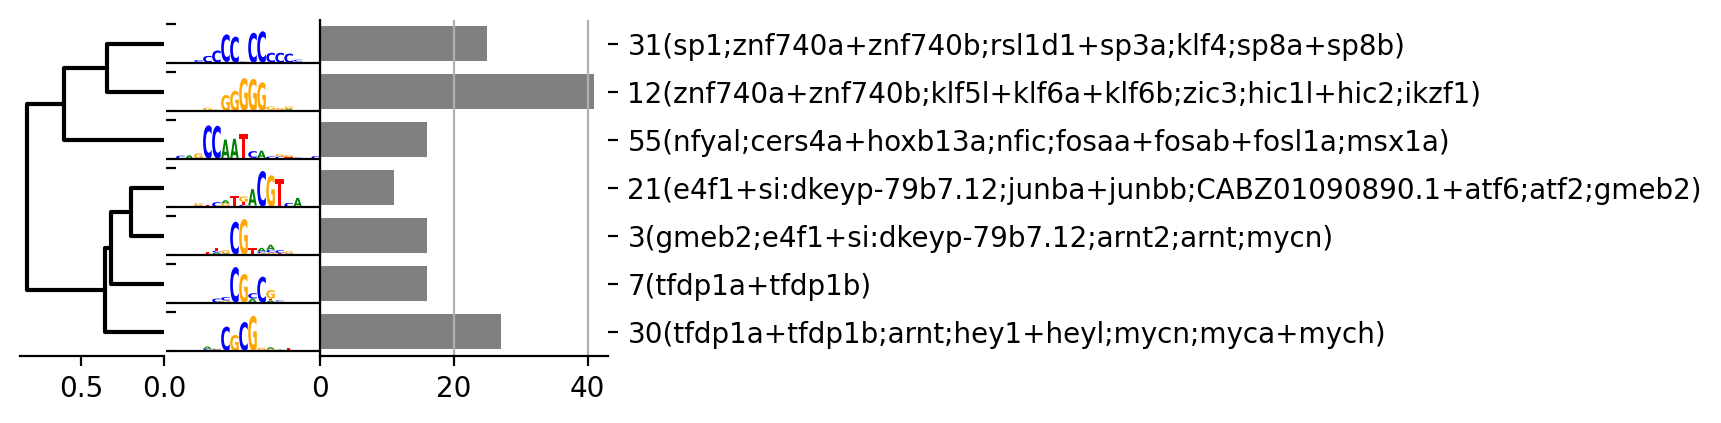

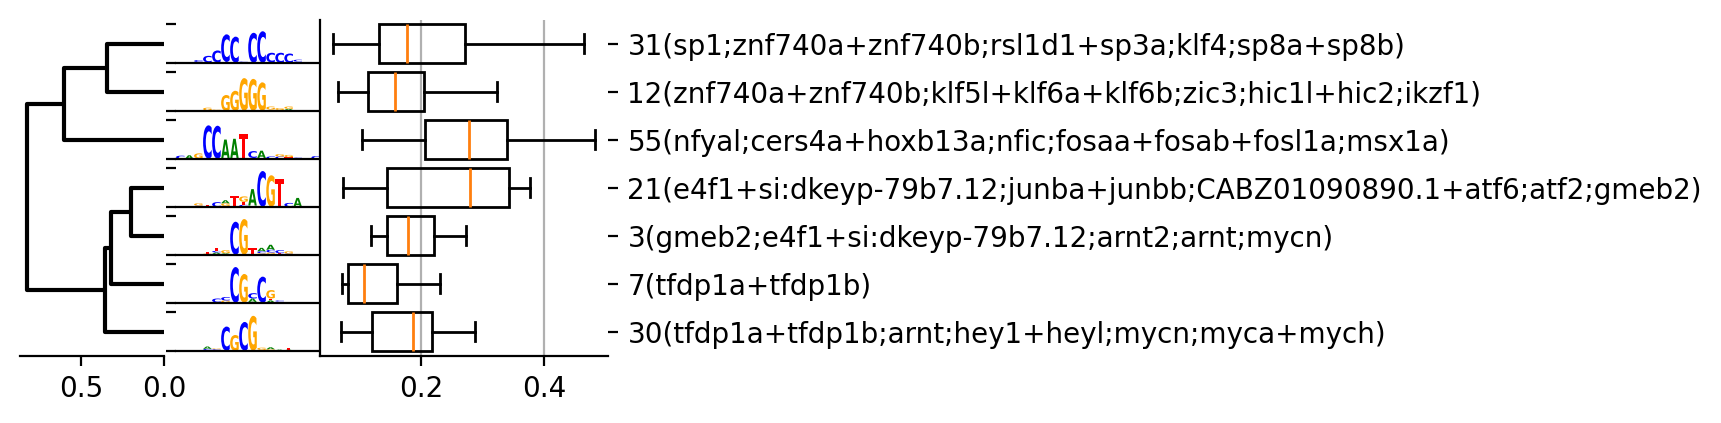

(None, [4, 1, 0, 3, 6, 2, 5])

In [67]:
import plotlib as drgplt

# Of the hundreds of clusters, let's restrict the plot to clusters in neural.crest and large clusters of n > 10
# Load saved seqlets
output_path = os.path.expanduser('../results/')
model_stem = best_checkpoint.replace('/', '.')
seqlet_file = os.path.join(output_path, model_stem) + '_seqlets.npz'
sfile = np.load(seqlet_file, allow_pickle= True)
selected_names, motif_names, header, normed_motifs, motif_mean_effect, motif_max_effect, motif_borders = sfile['seqnames'], sfile['names'], sfile['cells'], sfile['seqlets'], sfile['mean_effect'], sfile['max_effect'], sfile['borders']

motif_names = np.concatenate(motif_names, axis = 0)
motif_max_effect = np.concatenate(motif_max_effect, axis = 0)

# Load cluster motifs and ids
cwm_meme = os.path.splitext(seqlet_file)[0]+'_cluster_cwms.meme'
cluster_cwms, cluster_ids, nts = read_meme(cwm_meme, nameline = 'MOTIF')
cluster_ids = cluster_ids.astype(int)

# We load the cluster assignments from file
cluster_file = np.genfromtxt(os.path.splitext(seqlet_file)[0]+'_cluster.txt', dtype = str)
motif_names, clusters = cluster_file[:,0], cluster_file[:,1].astype(int)


motif_mask = np.array(['neural.crest' in mf for mf in motif_names])
cluster_ids_nc, n_seqlets_nc = np.unique(clusters[motif_mask], return_counts=True)
n_seqlets = np.zeros(len(cluster_ids))

# This only works if clusters and cluster_ids are integer, otherwise cluster_ids_nc will not be sorted as integer but as string
n_seqlets[np.isin(cluster_ids, cluster_ids_nc)] = n_seqlets_nc
cluster_mask = n_seqlets > 10
print(f'{np.sum(cluster_mask)} clusters have more than 10 seqlets')

selected_cluster_cwms = [cw for c, cw in enumerate(cluster_cwms) if cluster_mask[c]]
# Compute the correlation distance matrix between the selected cluster motifs
cwm_correlation = torch_compute_similarity_motifs(selected_cluster_cwms, selected_cluster_cwms, metric = 'correlation', min_sim = 4, 
                                                     padding = 0., infocont = False, bk_freq = 0.25, reverse_complement = True, 
                                                     verbose = False, batchsize = 1024, exact = True, fill_logp_self = 127, 
                                                     return_alignment = False)

drgplt.plot_heatmap(None, # matrix that is plotted with imshow
                 ydistmat = cwm_correlation, # matrix to compute sorty, default uses heatmat
                 sorty = 'average', # same as above but for y axis
                 pwms = selected_cluster_cwms, # pwms that are plotted with logomaker next to rows of matrix
                 infocont = False, 
                 yticklabels  = cluster_name[cluster_mask],
                 showdpi = 200, # dpi value for plotting with plt.show()
                 dpi = None, # dpi value for savefig
                 figname = None, # if given, figure saved under this name
                 fmt = '.jpg', # format of saved figure
                 maxsize = 150, # largest size the figure can take along both axis
                 cellsize = 0.3, # size of a single cell in the heatmap
                 cellratio = 1., # ratio of cells y/x
                 noheatmap = True, # if True, only tree is plotted
                 row_distributions = n_seqlets[cluster_mask].reshape(-1,1), # for each row in heatmap, add 
                 # a box or a bar plot with plot_distribution, 
                 row_distribution_kwargs = {'barplot':True} # kwargs fro plot_distribution
                 )


# Collect the max-effects of the different motif clusters for a specific cell types from motif_mean_effect
cluster_effect_sizes = []
for ci in cluster_ids[cluster_mask]:
    cluster_effect_sizes.append(motif_max_effect[(clusters == ci)*(motif_mask)])

drgplt.plot_heatmap(None, # matrix that is plotted with imshow
                 ydistmat = cwm_correlation, # matrix to compute sorty, default uses heatmat
                 sorty = 'average', # same as above but for y axis
                 pwms = selected_cluster_cwms, # pwms that are plotted with logomaker next to rows of matrix
                 infocont = False, 
                 yticklabels  = cluster_name[cluster_mask],
                 showdpi = 200, # dpi value for plotting with plt.show()
                 dpi = None, # dpi value for savefig
                 figname = None, # if given, figure saved under this name
                 fmt = '.jpg', # format of saved figure
                 maxsize = 150, # largest size the figure can take along both axis
                 cellsize = 0.3, # size of a single cell in the heatmap
                 cellratio = 1., # ratio of cells y/x
                 noheatmap = True, # if True, only tree is plotted
                 row_distributions = cluster_effect_sizes, # for each row in heatmap, add 
                 # a box or a bar plot with plot_distribution, 
                 row_distribution_kwargs = {} # kwargs fro plot_distribution
                 )
     

## Plot motifs in tree with detected number of occurrances, and mean, and max effect

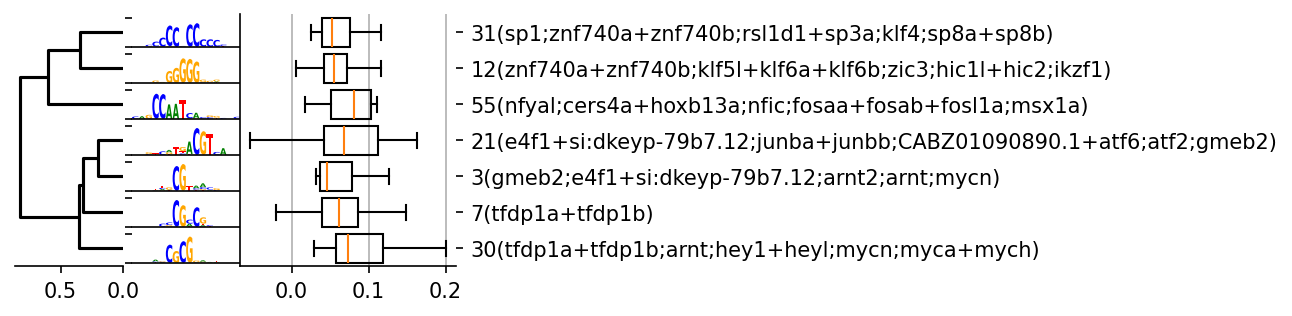

-0.09325924993004354 0.09325924993004354


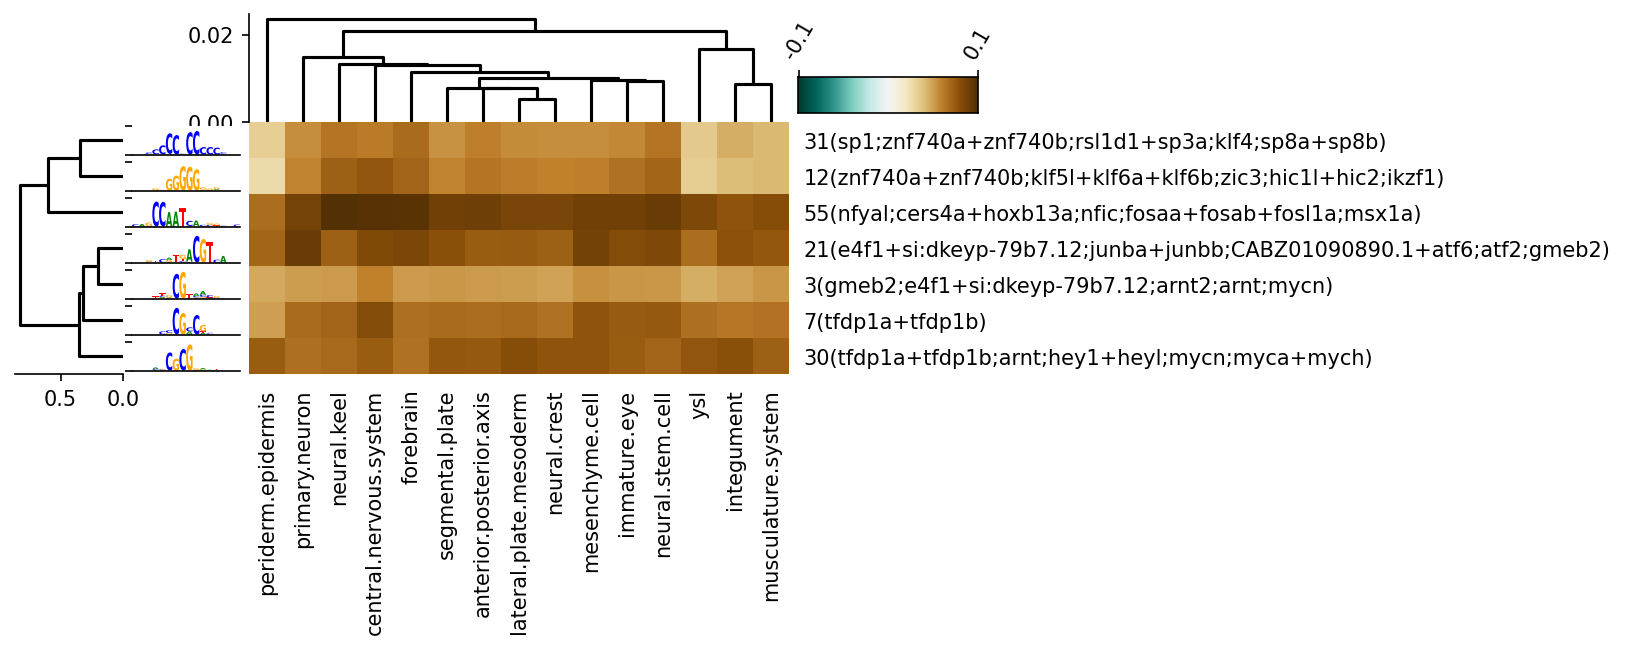

([11, 12, 9, 1, 2, 13, 0, 5, 8, 6, 3, 10, 14, 4, 7], [4, 1, 0, 3, 6, 2, 5])

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os

def shared_borders(p_list):
    n = len(p_list)
    shared_matrix = np.zeros((n, n), dtype=bool)
    for i in range(n):
        for j in range(i, n):
            shared_matrix[i, j] = np.intersect1d(p_list[i], p_list[j]).size > 0
    return shared_matrix

from scipy.sparse.csgraph import connected_components

def get_groups(shared_matrix):
    # Use connected_components to find groups
    n_components, labels = connected_components(csgraph=shared_matrix, directed=False)
    # Group indices by component
    groups = [np.where(labels == i)[0].tolist() for i in range(n_components)]
    return groups

def get_borders_of_groups(p_list, groups):
    new_borders = [np.unique(np.concatenate([p_list[gi] for gi in g])) for g in groups]
    return new_borders

def get_unique_motif_positions(p_list):
    shared_matrix = shared_borders(p_list)
    groups = get_groups(shared_matrix)
    unique_motif_borders = get_borders_of_groups(p_list, groups)
    return unique_motif_borders

def signed_absmax(arr, axis):
    """
    Find the absolute maximum with its original sign along a specified axis.
    Parameters:
    -----------
        arr (np.ndarray): Input array.
        axis (int): Axis along which to find the absolute maximum.
    Returns:
    --------
        np.ndarray: Array of absolute maximum values with their original sign.
    """
    # Get the indices of the absolute maximum values along the specified axis
    indices = np.argmax(np.abs(arr), axis=axis)
    
    # Use expand_dims to align the indices with the input array's shape
    expanded_indices = np.expand_dims(indices, axis=axis)
    
    # Extract the values with their original sign using take_along_axis
    abs_max_with_sign = np.take_along_axis(arr, expanded_indices, axis=axis)
    
    # Squeeze the result to remove the singleton dimension
    return np.squeeze(abs_max_with_sign, axis=axis)


def get_cluster_effects(stats,cluster_ids, header):
    cluster_effect_sizes = []
    #print(clusters, cluster_ids, clusters, header)
    cluster_median_matrix = np.zeros((len(cluster_ids), len(header)))
    for c, ci in enumerate(cluster_ids):
        cimask = clusters == ci
        cluster_effect = []
        # find unique sequences with that motif in one of the cell types
        uni_sequence = np.unique(motif_sequence[cimask])
        #print(uni_sequence)
        # for every sequence determine the joint start and end of the motifs
        for us in uni_sequence:
            unisemask = (motif_sequence == us)*cimask
            unipos = get_unique_motif_positions(motif_positions[unisemask])
            #print(unipos)
            seq_stats = stats[list(selected_names).index(us)]
            for up in unipos:
                cluster_effect.append(signed_absmax(seq_stats[:,up[0]:up[1]],-1))
                #print(cluster_effect[-1])
        cluster_effect_sizes.append(np.array(cluster_effect))
        cluster_median_matrix[c] = np.median(cluster_effect, axis = 0)
    
    return cluster_effect_sizes, cluster_median_matrix


# Load saved seqlets
output_path = os.path.expanduser('../results/')
model_stem = best_checkpoint.replace('/', '.')
seqlet_file = os.path.join(output_path, model_stem) + '_seqlets.npz'
sfile = np.load(seqlet_file, allow_pickle= True)
selected_names, motif_names, header, normed_motifs, motif_mean_effect, motif_max_effect, motif_borders = sfile['seqnames'], sfile['names'], sfile['cells'], sfile['seqlets'], sfile['mean_effect'], sfile['max_effect'], sfile['borders']

# Load cluster motifs and ids
cwm_meme = os.path.splitext(seqlet_file)[0]+'_cluster_cwms.meme'
cluster_cwms, cluster_ids, nts = read_meme(cwm_meme, nameline = 'MOTIF')
cluster_ids = cluster_ids.astype(int)

# We load the cluster assignments from file
cluster_file = np.genfromtxt(os.path.splitext(seqlet_file)[0]+'_cluster.txt', dtype = str)
motif_names, clusters = cluster_file[:,0], cluster_file[:,1].astype(int)

# from motif_names, assign peak name, track, and positions to motif
# TODO save this in seqlet file 
motif_borders = np.concatenate(motif_borders, axis = 0)
motif_sequence, motif_track, motif_positions = [], [], []
for m, mn in enumerate(motif_names):
    mn = mn.split('_')
    motif_sequence.append(mn[0])
    motif_track.append(mn[1])
    motif_positions.append(np.arange(motif_borders[m,0],motif_borders[m,1],dtype = int))
motif_sequence, motif_track, motif_positions = np.array(motif_sequence), np.array(motif_track), np.array(motif_positions, dtype = object)


# For each cluster, find all the instances of a motif
# align them if they are from two different cell types
# now extract max and mean attribution across all cell types
stats = np.sum(gradattr * selected_seqs_one_hot[:, None], axis = -2)


cluster_effect_sizes, cluster_median_matrix = get_cluster_effects(stats, cluster_ids, header)

# Plot box plot again for neural.crest but now including the times a motif shows up in another cell type
drgplt.plot_heatmap(None, # matrix that is plotted with imshow
                 ydistmat = cwm_correlation, # matrix to compute sorty, default uses heatmat
                 sorty = 'average', # same as above but for y axis
                 pwms = selected_cluster_cwms, # pwms that are plotted with logomaker next to rows of matrix
                 infocont = False, 
                 yticklabels  = cluster_name[cluster_mask],
                 showdpi = 150, # dpi value for plotting with plt.show()
                 dpi = None, # dpi value for savefig
                 figname = None, # if given, figure saved under this name
                 fmt = '.jpg', # format of saved figure
                 maxsize = 150, # largest size the figure can take along both axis
                 cellsize = 0.3, # size of a single cell in the heatmap
                 cellratio = 1., # ratio of cells y/x
                 noheatmap = True, # if True, only tree is plotted
                 row_distributions = [ces[:,8] for c, ces in enumerate(cluster_effect_sizes) if cluster_mask[c]], # for each row in heatmap, add 
                 # a box or a bar plot with plot_distribution, 
                 row_distribution_kwargs = {} # kwargs fro plot_distribution
                 )

# Plot heat map with all median effect sizes for all cell types.
drgplt.plot_heatmap(cluster_median_matrix[cluster_mask], # matrix that is plotted with imshow
                 ydistmat = cwm_correlation, # matrix to compute sorty, default uses heatmat
                 sorty = 'average', # same as above but for y axis
                 sortx = 'single',
                 measurex = 'euclidean',
                 pwms = selected_cluster_cwms, # pwms that are plotted with logomaker next to rows of matrix
                 infocont = False, 
                 yticklabels  = cluster_name[cluster_mask],
                 xticklabels = header,
                 showdpi = 150, # dpi value for plotting with plt.show()
                 dpi = None, # dpi value for savefig
                 figname = None, # if given, figure saved under this name
                 fmt = '.jpg', # format of saved figure
                 vmin = -np.amax(np.abs(cluster_median_matrix[cluster_mask])),
                 vmax = np.amax(np.abs(cluster_median_matrix[cluster_mask])),
                 maxsize = 150, # largest size the figure can take along both axis
                 cellsize = 0.3, # size of a single cell in the heatmap
                 cellratio = 1., # ratio of cells y/x
                 noheatmap = False, # if True, only tree is plotted
                 row_distribution_kwargs = {} # kwargs fro plot_distribution
)   
